In [1]:
import json
import configparser
import os
import os.path as osp
import pprint
import pandas as pd
from pandas_profiling import ProfileReport
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from typing import List
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
config_file_path = osp.join(os.getcwd(), 'config.ini')
parser = configparser.ConfigParser()
parser.read(config_file_path)

['d:\\Deakin\\Lifelog-Annotation-Analysis\\config.ini']

In [3]:
def read_file(file_path):
    """
    Read prediction results from neural network
    """
    user_id, date, file_name = file_path.split('/')[-3:]
    image_id = '/'.join([user_id, date, osp.splitext(file_name)[0]])
    lines = [line.strip() for line in open(file_path, 'r').readlines()]
    return user_id, date, image_id, lines

# Load and explore the data

## Explore the Image Annotation database

In [5]:
# Load Users data and explore the annotated User ID and the data's date
database_path = parser['PATH']['database_path']
file = open(osp.join(database_path, 'User.json'), 'r')
users = [json.loads(line) for line in file.readlines()]
user_data_info = {}
for item in users:
    dates = [_item['date'] for _item in item['data']]
    user_data_info[item['user_id']] = dates
pprint.pprint(user_data_info)

{'1': ['2016_10_26', '2016_10_27'],
 '2': ['2016_10_28', '2016_10_29', '2016_10_30', '2016_10_31', '2016_11_01'],
 '3': ['2016_11_02', '2016_11_03', '2016_11_04', '2016_11_05'],
 '5': ['2016_11_10', '2016_11_11', '2016_11_12'],
 '83-103': ['2016_06_27'],
 '83-105': ['2016_08_02'],
 '83-109': ['2016_09_14', '2016_09_15'],
 '83-117': ['2016_10_31',
            '2016_11_01',
            '2016_11_02',
            '2016_11_03',
            '2016_11_04',
            '2016_11_05',
            '2016_11_06',
            '2016_11_07'],
 '83-120': ['2016_11_10',
            '2016_11_11',
            '2016_11_12',
            '2016_11_13',
            '2016_11_14',
            '2016_11_15',
            '2016_11_16'],
 'Cathal': ['2015_02_23']}


In [6]:
# Load ImageAnnotation data and explore first item of ImageAnnotation data format
file = open(osp.join(database_path, 'ImageAnnotation.json'), 'r')
annotations = [json.loads(line) for line in file.readlines()]
# annotations = json.loads(annotations)
df = pd.json_normalize(annotations)

In [7]:
# Select columns for analysis
annotation_columns = df.columns[df.columns.str.startswith('annotation')].tolist()
columns = ['user_id', 'date', 'image_id', 'annotated', *annotation_columns]
filtered_df = df[columns]

In [14]:
# Visualizing data summarization into a html report 
prof = ProfileReport(filtered_df)
prof.to_file(output_file='report.html')

C:\Users\nvtu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 125.79it/s]


### Due to the report, there were some errors of the annotation implementation of medication consumptions
### Let's analyze the number of rows that we can ensure we do not need to annotate them.

In [9]:
# Get rows where beverages and food columns have NaN values --> is one of these columns has NaN value, we need to consider re-annotate the rows.
# filtered_df[['annotation.consumptions.beverages', 'annotation.consumptions.food', 'annotation.consumptions.medications']].value_counts()
filtered_df[['annotation.consumptions.beverages', 'annotation.consumptions.food', 'annotation.consumptions.medications']].value_counts()

annotation.consumptions.beverages  annotation.consumptions.food  annotation.consumptions.medications
False                              False                         False                                  24257
True                               False                         False                                   1725
False                              True                          False                                    856
True                               True                          False                                    634
False                              True                          True                                      76
True                               True                          True                                      65
False                              False                         True                                      12
dtype: int64

## Explore Places365CNN data

In [8]:
places365CNN_data_path = parser['PATH']['places365CNN_data_path']
scene_category_data_path = osp.join(places365CNN_data_path, 'Categories', 'pred')
scene_attribute_data_path = osp.join(places365CNN_data_path, 'Attributes', 'pred')

In [18]:
# Load scene categories
scene_category_dict = defaultdict(list)
for root, dirs, files in os.walk(scene_category_data_path):
    for file in tqdm(files):
        file_path = osp.join(root, file).replace('\\', '/')
        user_id, date, image_id, lines = read_file(file_path)
        environment = lines[0].split(' -> ')[-1]
        for item in lines[1:]:
            score, scene_category = item.split(' -> ')
            scene_category_dict[image_id].append([environment, scene_category, float(score)])

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1120/1120 [00:00<00:00, 9572.78it/s]
0it [00:00, ?it/s]
100%|██████████| 869/869 [00:00<00:00, 8355.84it/s]
0it [00:00, ?it/s]
100%|██████████| 951/951 [00:00<00:00, 10010.45it/s]
0it [00:00, ?it/s]
100%|██████████| 725/725 [00:00<00:00, 9666.69it/s]
0it [00:00, ?it/s]
100%|██████████| 1272/1272 [00:00<00:00, 10013.56it/s]
0it [00:00, ?it/s]
100%|██████████| 97/97 [00:00<00:00, 8819.20it/s]


Text(0.5, 1.0, 'Distribution of scene categories prediction scores')

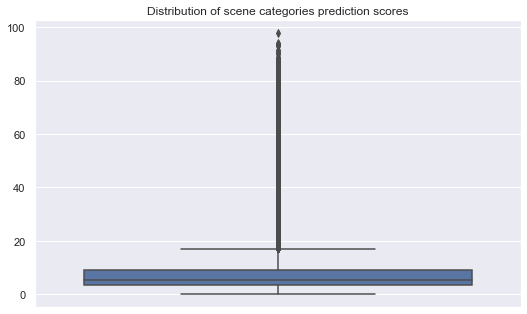

In [19]:
# Visualize the distribution of scene categories prediction scores
prediction_scores = []
for _, values in scene_category_dict.items():
    prediction_scores += [item[-1] * 100 for item in values]
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.boxplot(y = prediction_scores).set_title("Distribution of scene categories prediction scores")

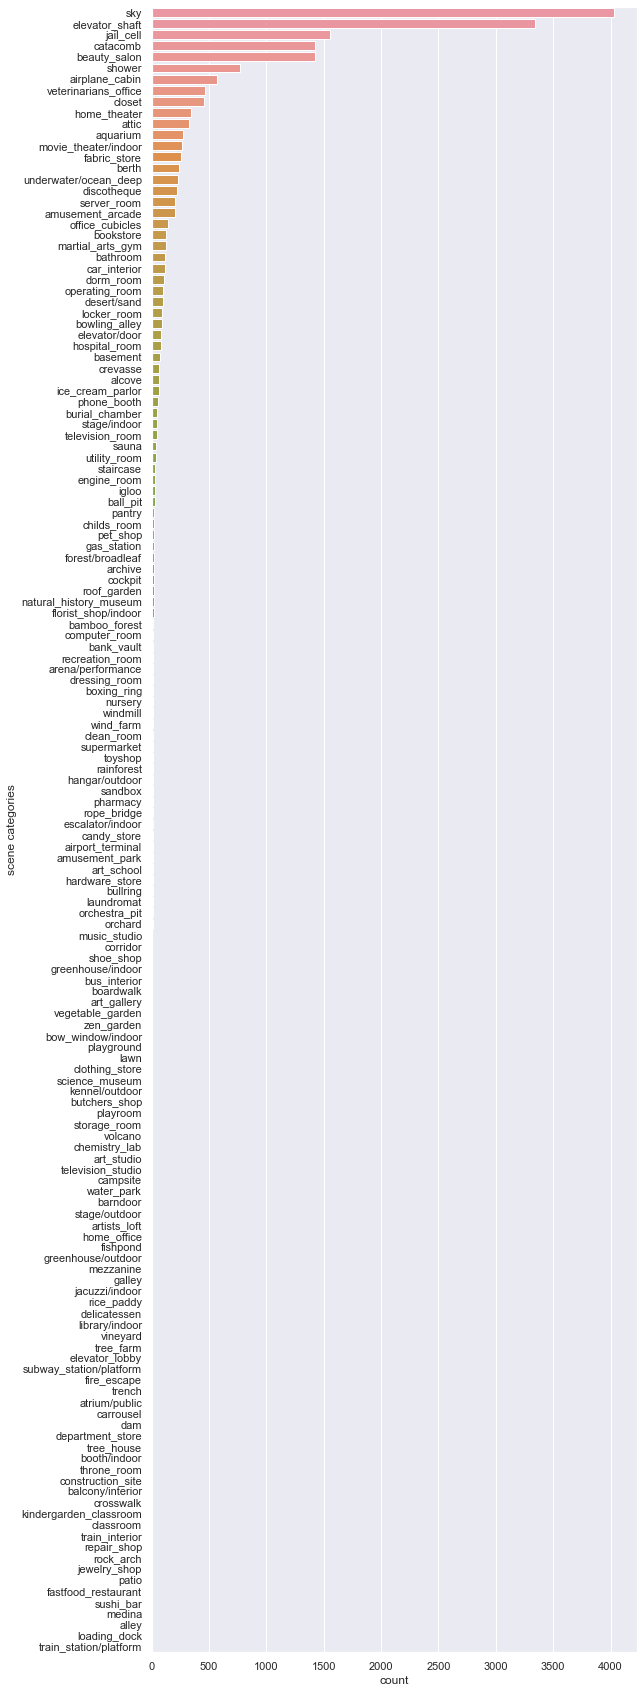

In [28]:
# Visualize the distribution of scene categories counter
scene_categories = []
for _, values in scene_category_dict.items():
    scene_categories += [item[1] for item in values if item[-1] >= 0.15]
cnt_summarized = Counter(scene_categories)
scene_categories_df = pd.DataFrame.from_dict(cnt_summarized, orient='index').reset_index().rename(columns={'index': 'scene categories', 0: 'count'}).sort_values(by = 'count', ascending = False)

# Visualize it
sns.set(rc={'figure.figsize':(8.7,30.27)})
ax = sns.barplot(x = 'count', y = 'scene categories', data = scene_categories_df)

In [21]:
# Load scene attributes
scene_attribute_dict = defaultdict(list)
for root, dirs, files in os.walk(scene_attribute_data_path):
    for file in tqdm(files):
        file_path = osp.join(root, file).replace('\\', '/')
        user_id, date, image_id, lines = read_file(file_path)
        scene_attribute_dict[image_id] += [line.split(', ') for line in lines]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1120/1120 [00:00<00:00, 8682.33it/s]
0it [00:00, ?it/s]
100%|██████████| 869/869 [00:00<00:00, 10105.30it/s]
0it [00:00, ?it/s]
100%|██████████| 951/951 [00:02<00:00, 359.02it/s]
0it [00:00, ?it/s]
100%|██████████| 725/725 [00:02<00:00, 288.04it/s]
0it [00:00, ?it/s]
100%|██████████| 1272/1272 [00:04<00:00, 281.84it/s]
0it [00:00, ?it/s]
100%|██████████| 97/97 [00:00<00:00, 274.03it/s]


## Explore Yolov4Detections data

In [168]:
# Load Yolov4Detections data
yolov4Detections_data_path = parser['PATH']['yolov4Detections_data_path']
yolov4Detections_dict = defaultdict(list)
for root, dirs, files in os.walk(yolov4Detections_data_path):
    for file in files:
        if osp.splitext(file)[-1] == '.txt':
            file_path = osp.join(root, file).replace('\\','/')
            user_id, date, image_id, lines = read_file(file_path)
            for item in lines:
                item = item.split()
                object_label, bbox, confidence_score = ' '.join(item[:-5]), '{} {} {} {}'.format(*item[-5:-1]), float(item[-1])
                yolov4Detections_dict[image_id].append([object_label, confidence_score, bbox])

In [169]:
# Compute the number of images that has object detected for each user
detected_object_cnt = {}
total_detected_images = len(yolov4Detections_dict.keys())
for key, values in yolov4Detections_dict.items():
    user_id = key.split('/')[0]
    try: 
        detected_object_cnt[user_id] += 1
    except:
        detected_object_cnt[user_id] = 1
print(detected_object_cnt)
print(f"Total number of images that has object detected by Yolov4: {total_detected_images}")

{'83-103': 14, '83-105': 230, '83-109': 1193, '83-116': 7808, '83-117': 974, '83-120': 1742}
Total number of images that has object detected by Yolov4: 11961


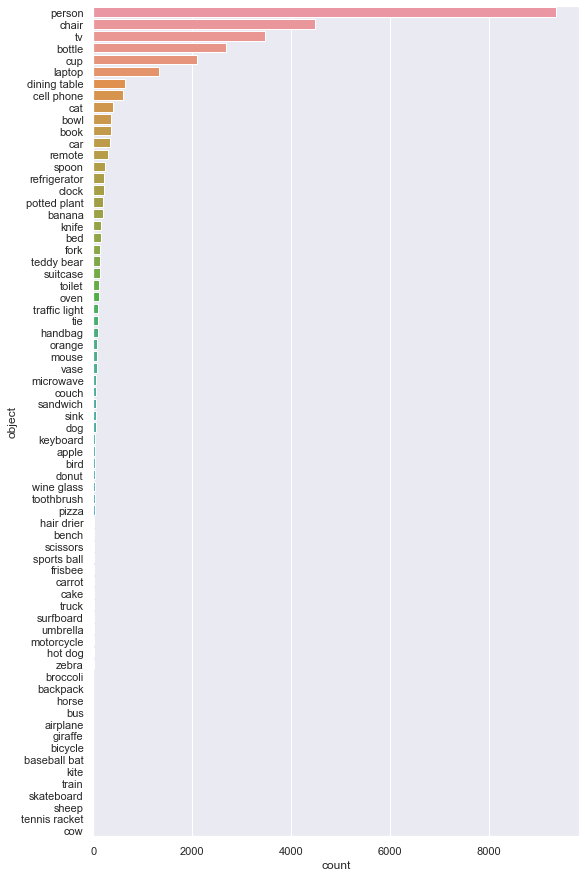

In [170]:
# Visualize the distribution of object detected from yolov4Detections
object_user_list = []
for _, values in yolov4Detections_dict.items():
    object_user_list += [item[0] for item in values]
cnt_summarized = Counter(object_user_list)
yolov4count_df = pd.DataFrame.from_dict(cnt_summarized, orient='index').reset_index().rename(columns={'index': 'object', 0: 'count'}).sort_values(by = 'count', ascending = False)

# Visualize it
sns.set(rc={'figure.figsize':(8.7,15.27)})
ax = sns.barplot(x = 'count', y = 'object', data = yolov4count_df)

Text(0.5, 1.0, 'Distribution of object counts')

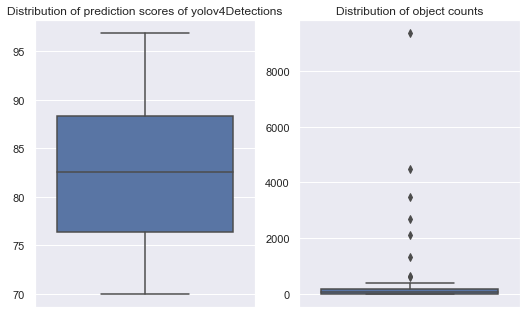

In [45]:
# Visualize the distribution of prediction scores of yolov4Detections and the number of object detected
score_user_list = []
for _, values in yolov4Detections_dict.items():
    score_user_list += [item[1] * 100 for item in values]

sns.set(rc={'figure.figsize':(8.7,5.27)})
fig, axs = plt.subplots(ncols = 2)
sns.boxplot(y = score_user_list, ax = axs[0]).set_title("Distribution of prediction scores of yolov4Detections")
sns.boxplot(y = yolov4count_df['count'].tolist(), ax = axs[1]).set_title("Distribution of object counts")

# Prepare the dataset structure for analyzing

### - Filter annotated activities rows and fix user_id 1, 2, 3, 5 and their image_ids to 83-116 as well as removing the image_ids extension
### - Filter the image_ids that has object detected by Yolov4 

In [46]:
# Get annotated activities rows
annotated_df = filtered_df[filtered_df['annotated'] == True] # Get annotated rows
# Fix user_id 1, 2, 3, 5 and their image_ids to 83-116
annotated_df['user_id'].replace(['1', '2', '3', '5'], '83-116', inplace = True)
annotated_df.loc[annotated_df['user_id'] == '83-116', 'image_id'] = annotated_df.loc[annotated_df['user_id'] == '83-116', 'image_id'].apply(lambda x: f'83-116{x[1:]}')
# Remove the image_ids extension
annotated_df.loc[:, 'image_id'] = annotated_df['image_id'].apply(lambda x: osp.splitext(x)[0])

C:\Users\nvtu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\nvtu\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# The accuracy of places365CNN environment compared to the annotations

In [58]:
# Keep annotation.locations columns
annotation_location_cols = annotated_df.columns[annotated_df.columns.str.startswith('annotation.locations')].tolist()
annotated_locations_df = annotated_df[['user_id', 'date', 'image_id', *annotation_location_cols]]

In [67]:
annotated_locations_df[['annotation.locations.indoor', 'annotation.locations.outdoor', 'annotation.locations.home']].value_counts()

annotation.locations.indoor  annotation.locations.outdoor  annotation.locations.home
True                         False                         True                         18498
False                        False                         False                         6579
True                         False                         False                         3787
False                        True                          False                         1062
                                                           True                           438
                             False                         True                             1
dtype: int64

In [71]:
# Extract environment annotation
environment_annotation_dict = {}
target_cols = ['image_id', 'annotation.locations.indoor', 'annotation.locations.outdoor']
for value in annotated_locations_df[target_cols].values:
    image_id, indoor, outdoor = value
    if (indoor | outdoor) == False: continue 
    environment_annotation_dict[image_id] = 'indoor' if indoor == True else 'outdoor'

In [84]:
 # Get the environment inference from places365CNN and compare its accuracy compared to the ground-truth
 hits = 0
 total_matches = len(scene_category_dict.keys())
 for image_id, values in scene_category_dict.items():
    scene_category_env = values[0][0]
    try:
        if scene_category_env == environment_annotation_dict[image_id]:
            hits += 1
    except:
        total_matches -= 1;
accuracy = hits / total_matches * 100
print(f"LOCATION ENVIRONMENT PREDICTION ACCURACY: {accuracy}")

LOCATION ENVIRONMENT PREDICTION ACCURACY: 92.90349768225875


# Training rule-based activity classification

In [241]:
# Keep annotation.activities columns
annotation_activities_cols = annotated_df.columns[annotated_df.columns.str.startswith('annotation.activities')].tolist()
annotation_activities_cols.remove('annotation.activities.housework')
annotation_activities_cols.remove('annotation.activities.physical_activities')
annotation_activities_cols.remove('annotation.activities.sedentary')
annotated_activities_df = annotated_df[['user_id', 'date', 'image_id', *annotation_activities_cols]]
# Filter the image_ids that has object detected by Yolov4
annotated_activities_df = annotated_activities_df[annotated_df['image_id'].isin(yolov4Detections_dict.keys())]

In [242]:
annotated_activities_df.groupby(['user_id', 'date']).sum()
# .agg({'image_id': 'count'})

annotation.activities.cooking  \
user_id date                                        
83-103  2016_06_27                              0   
83-109  2016_09_14                             24   
        2016_09_15                             24   
83-116  2016_10_26                              0   
        2016_10_27                              0   
        2016_10_28                              0   
        2016_10_29                              0   
        2016_10_30                              0   
        2016_10_31                              4   
        2016_11_01                              0   
        2016_11_02                              0   
        2016_11_03                              0   
        2016_11_04                              0   
        2016_11_05                              1   
        2016_11_10                              0   
        2016_11_11                              3   
        2016_11_12                              0   
83-117  2016_10_31                              0   
        2016_11_01                              0   
        2016_11_02                              0   
        2016_11_03                              0   
        2016_11_04                              0   
        2016_11_05                              0   
        2016_11_06                              0   
        2016_11_07                              0   
83-120  2016_11_10                              0   
        2016_11_11                              0   
        2016_11_12                              0   
        2016_11_13                              0   
        2016_11_14                              0   
        2016_11_15                              0   
        2016_11_16                              0   

                    annotation.activities.eating  \
user_id date                                       
83-103  2016_06_27                             0   
83-109  2016_09_14                            74   
        2016_09_15                            73   
83-116  2016_10_26                            21   
        2016_10_27                            67   
        2016_10_28                            10   
        2016_10_29                             0   
        2016_10_30                             0   
        2016_10_31                             0   
        2016_11_01                             0   
        2016_11_02                            12   
        2016_11_03                            37   
        2016_11_04                             3   
        2016_11_05                            33   
        2016_11_10                             8   
        2016_11_11                             2   
        2016_11_12                             0   
83-117  2016_10_31                             0   
        2016_11_01                             1   
        2016_11_02                             5   
        2016_11_03                             0   
        2016_11_04                             4   
        2016_11_05                             3   
        2016_11_06                             1   
        2016_11_07                             0   
83-120  2016_11_10                             2   
        2016_11_11                             9   
        2016_11_12                             6   
        2016_11_13                             3   
        2016_11_14                             1   
        2016_11_15                             0   
        2016_11_16                             0   

                    annotation.activities.drinking  \
user_id date                                         
83-103  2016_06_27                               0   
83-109  2016_09_14                               9   
        2016_09_15                              11   
83-116  2016_10_26                               1   
        2016_10_27                              11   
        2016_10_28                               8   
        2016_10_

In [243]:
# Construct ground-truth for multi-label activity classification
image_ids = []
ground_truth_activities = []
envs = {}
predicted_scenes = {}
target_cols = ['image_id', *annotation_activities_cols]
for values in annotated_activities_df[target_cols].values:
    image_id = values[0]
    if any(values[1:]) == False: continue
    image_ids.append([image_id])
    predicted_scenes[image_id] = scene_category_dict[image_id][1][1] # Get top 1 scene category inference
    try:
        envs[image_id] = environment_annotation_dict[image_id]
    except:
        envs[image_id] = None
    ground_truth_activities.append([index+1 for index, value in enumerate(values[1:]) if value == True])
mlb = MultiLabelBinarizer()
ground_truth_activities = mlb.fit_transform(ground_truth_activities)

In [244]:
# Sampling split image_id for training
X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(image_ids), ground_truth_activities, test_size = 0.2)
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row)
}).T.fillna(0.0)

,"(7,)","(3,)","(6,)","(4,)","(5,)","(2,)","(0,)","(1,)","(8,)"
train,823,13,66,3947,264,66,45,300,251
test,206,3,16,987,66,17,11,75,63


In [245]:
label_mapping = ['cooking', 'eating', 'drinking', 'gardening', 'screen_time', 'reading', 'hygiene_in_bathroom', 'socializing', 'shopping']
activities_object_dict = defaultdict(list)
activities_object_cnt = defaultdict(dict)
activities_environment = defaultdict(list)
activities_scene = defaultdict(list)
for index, image_id in enumerate(X_train):
    image_id = image_id[0]
    ground_truth = y_train[index]
    for i in range(len(ground_truth)):
        if ground_truth[i] == 1:
            activities_environment[label_mapping[i]].append(envs[image_id])
            activities_scene[label_mapping[i]].append(predicted_scenes[image_id])
            activities_object = [item[0] for item in yolov4Detections_dict[image_id] if item[1] > 0.8]
            activities_object_dict[label_mapping[i]] += activities_object
            for key in Counter(activities_object):
                try:
                    activities_object_cnt[label_mapping[i]][key] += 1
                except:
                    activities_object_cnt[label_mapping[i]][key] = 1

for activity_label, values in activities_object_dict.items():
    object_cnt_summary = Counter(values).most_common(10)
    environment_cnt_summary = Counter(activities_environment[activity_label]).most_common(1)
    scene_cnt_summary = Counter(activities_scene[activity_label]).most_common(5)
    # for key in cnt_summary.keys():
    #     cnt_summary[key] /= max(1, activities_object_cnt[activity_label][key])
    # total = sum(cnt_summary.values())
    # for key in cnt_summary.keys():
    #     cnt_summary[key] /= total
    print(activity_label)
    print(object_cnt_summary)
    print(environment_cnt_summary)
    print(scene_cnt_summary)
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

socializing
[('person', 1228), ('cup', 473), ('bottle', 220), ('chair', 213), ('dining table', 106), ('cell phone', 65), ('tv', 19), ('spoon', 18), ('bowl', 10), ('clock', 7)]
[('indoor', 789)]
[('elevator_shaft', 74), ('beauty_salon', 73), ('shower', 54), ('jail_cell', 41), ('dressing_room', 40)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
gardening
[('person', 7), ('bird', 1)]
[('outdoor', 12)]
[('roof_garden', 3), ('vegetable_garden', 2), ('jail_cell', 1), ('rainforest', 1), ('water_park', 1)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
hygiene_in_bathroom
[('person', 18), ('toilet', 14), ('bottle', 13), ('cup', 5), ('sink', 3), ('cat', 2), ('clock', 1), ('bed', 1), ('toothbrush', 1)]
[('indoor', 66)]
[('shower', 17), ('bathroom', 12

In [251]:
def compute_kendall_tau_score(rank_list_index):
    # Compute Kendall's Tau score
    cnt_concordant_pairs = 0
    cnt_discordant_pairs = 0
    for index, rank in enumerate(rank_list_index):
        cnt_concordant_pairs += sum(rank_list_index[index:] > rank)
        cnt_discordant_pairs += sum(rank_list_index[index:] < rank)
    kendall_tau_score = (cnt_concordant_pairs - cnt_discordant_pairs) / max(1, (cnt_concordant_pairs + cnt_discordant_pairs))
    return kendall_tau_score

In [312]:
def rule_based_kendall_tau(detected_objects: List[str], scene_category: str, environment_inference: str):
    labels = ['cooking', 'eating', 'drinking', 'gardening', 'screen_time', 'reading', 'hygiene_in_bathroom', 'socializing', 'shopping']
    predefined_activities_rank_list = {
        'cooking': ['cup', 'chair', 'dining table', 'knife', 'oven', 'spoon', 'bottle', 'bowl', 'microwave'],
        'eating': ['chair', 'cup', 'bowl', 'bottle', 'spoon', 'knife', 'fork'],
        'drinking': ['cup', 'bottle', 'dining table'],
        'gardening': ['bird'],
        'screen_time': ['person', 'chair', 'tv', 'laptop', 'cell phone', 'remote'],
        'reading': ['chair', 'book', 'laptop', 'couch'],
        'hygiene_in_bathroom': ['toilet', 'sink', 'toothbrush'],
        'socializing': ['person', 'chair', 'tv', 'cup', 'laptop', 'cell phone', 'dining table'],
        'shopping': ['person', 'handbag', 'bottle']
    }

    predefined_locations_rank_list = {
        'gardening': ['roof_garden', 'vegetable_garden'],
        'hygiene_in_bathroom': ['shower', 'bathroom'],
        'shopping': ['superartket', 'pet_shop', 'toyshop']
    }

    predefined_environment_rank_list = {
        'gardening': 'outdoor',
        'hygiene_in_bathroom': 'indoor',
        'screen_time': 'indoor',
        'socializing': 'indoor',
    }

    kd_scores = []
    
    # Inference for activity based on the detected objects in the images
    for activity in predefined_activities_rank_list.keys():
        intersection = [item for item in predefined_activities_rank_list[activity] if item in detected_objects]
        rank_list_index = [(predefined_activities_rank_list[activity].index(item), detected_objects.index(item)) for item in intersection]
        detected_object_rl_index = np.array([item[1] for item in rank_list_index])
        # Compute Kendall's Tau score
        kendall_tau_score = compute_kendall_tau_score(detected_object_rl_index)
        kd_scores.append(kendall_tau_score)
    return kd_scores

In [407]:
def infer(detected_objects: List[str], scene_category: str, environment_inference: str, kd_scores_by_activity):
    labels = ['cooking', 'eating', 'drinking', 'gardening', 'screen_time', 'reading', 'hygiene_in_bathroom', 'socializing', 'shopping']
    predefined_activities_rank_list = {
        'cooking': ['cup', 'chair', 'dining table', 'knife', 'oven', 'spoon', 'bottle', 'bowl', 'microwave'],
        'eating': ['chair', 'cup', 'bowl', 'bottle', 'spoon', 'knife', 'fork'],
        'drinking': ['cup', 'bottle', 'dining table'],
        'gardening': ['bird'],
        'screen_time': ['person', 'chair', 'tv', 'laptop', 'cell phone', 'remote'],
        'reading': ['chair', 'book', 'laptop', 'couch'],
        'hygiene_in_bathroom': ['toilet', 'sink', 'toothbrush'],
        'socializing': ['person', 'chair', 'tv', 'cup', 'laptop', 'cell phone', 'dining table'],
        'shopping': ['person', 'handbag', 'bottle']
    }

    predefined_locations_rank_list = {
        'gardening': ['roof_garden', 'vegetable_garden'],
        'hygiene_in_bathroom': ['shower', 'bathroom'],
        'shopping': ['supermartket', 'pet_shop', 'toyshop']
    }

    predefined_environment_rank_list = {
        'gardening': 'outdoor',
        'hygiene_in_bathroom': 'indoor',
        'screen_time': 'indoor',
        'socializing': 'indoor',
    }
    answers = []
    # Inference for special activity correlated with special environment
    for activity in predefined_locations_rank_list.keys():
        if scene_category in predefined_locations_rank_list[activity] and (activity in predefined_environment_rank_list and environment_inference == predefined_environment_rank_list[activity]):
            answers.append(activity)
    # Inference for activity based on the detected objects in the images
    for activity in predefined_activities_rank_list.keys():
        intersection = [item for item in predefined_activities_rank_list[activity] if item in detected_objects]
        rank_list_index = [(predefined_activities_rank_list[activity].index(item), detected_objects.index(item)) for item in intersection]
        detected_object_rl_index = np.array([item[1] for item in rank_list_index])
        # Compute Kendall's Tau score
        kendall_tau_score = compute_kendall_tau_score(detected_object_rl_index)
        try:
            if kendall_tau_score >= kd_scores_by_activity[activity] and kendall_tau_score > 0:
                answers.append(activity)
        except:
            if kendall_tau_score > 0:
                answers.append(activity)
    return answers

In [384]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

## Training

In [385]:
kd_scores = {}
for index, image_id in tqdm(enumerate(X_train)):
    image_id = image_id[0]
    ground_truth = y_train[index]
    environment_inference = scene_category_dict[image_id]
    scene_category = predicted_scenes[image_id]
    detected_objects = Counter([item[0] for item in yolov4Detections_dict[image_id] if item[1] > 0.8]).most_common(10)
    detected_objects = [item[0] for item in detected_objects]
    kd_score = rule_based_kendall_tau(detected_objects, scene_category, environment_inference)
    kd_scores[image_id] = kd_score

5449it [00:00, 9695.88it/s]


In [409]:
labels = ['cooking', 'eating', 'drinking', 'gardening', 'screen_time', 'reading', 'hygiene_in_bathroom', 'socializing', 'shopping']
kd_scores_by_activity = defaultdict(list)
for index, image_id in tqdm(enumerate(X_train)):
    image_id = image_id[0]
    ground_truth = y_train[index]
    for i in range(len(ground_truth)):
        if ground_truth[i] == 1 and kd_scores[image_id][i] > 0:
            kd_scores_by_activity[labels[i]].append(kd_scores[image_id][i])
for activity in kd_scores_by_activity.keys():
    kd_scores_by_activity[activity] = np.mean(kd_scores_by_activity[activity])

5449it [00:00, 217940.46it/s]


In [410]:
kd_scores_by_activity

defaultdict(list,
            {'screen_time': 0.8628136200716847,
             'cooking': 0.738095238095238,
             'drinking': 1.0,
             'eating': 0.8666666666666666,
             'reading': 1.0,
             'socializing': 0.7932555123216601,
             'shopping': 1.0})

In [411]:
labels = ['cooking', 'eating', 'drinking', 'gardening', 'screen_time', 'reading', 'hygiene_in_bathroom', 'socializing', 'shopping']
answers = {}
y_train_pred = np.zeros(y_train.shape)
for index, image_id in tqdm(enumerate(X_train)):
    image_id = image_id[0]
    ground_truth = y_train[index]
    environment_inference = scene_category_dict[image_id]
    scene_category = predicted_scenes[image_id]
    detected_objects = Counter([item[0] for item in yolov4Detections_dict[image_id] if item[1] > 0.8]).most_common(10)
    detected_objects = [item[0] for item in detected_objects]
    answers[image_id] = list(set(infer(detected_objects, scene_category, environment_inference, kd_scores_by_activity)))
    for item in answers[image_id]:
        _index = labels.index(item)
        y_train_pred[_index] = 1

0it [00:00, ?it/s]<ipython-input-407-7a4099097e70>:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if kendall_tau_score >= kd_scores_by_activity[activity] and kendall_tau_score > 0:
5449it [00:00, 10538.79it/s]


In [412]:
print("------------------ EXACT MATCH RATIO & PRECISION: ACCURACY FOR SINGLE-LABEL ACTIVITY CLASSIFICATION --------------------")
for index, label, in enumerate(labels):
    exact_match_ratio = accuracy_score(y_train[:, index], y_train_pred[:, index])
    precision = precision_score(y_train[:, index], y_train_pred[:, index])
    recall = recall_score(y_train[:, index], y_train_pred[:, index])
    print(f'{label} --- EMR: {(exact_match_ratio * 100).round(2)} --- Precision: {(precision).round(2)} --- Recall: {(recall).round(2)}')
print("------------------ OVERALL ACCURACY: THE AVERAGE ACCURACY ACROSS ALL INSTANCES (MULTI-LABEL ACTIVITIES EXACT MATCHING) --------------------- ")
print(f"Accuracy: {(hamming_score(y_train, y_train_pred) * 100).round(2)}")

------------------ EXACT MATCH RATIO & PRECISION: ACCURACY FOR SINGLE-LABEL ACTIVITY CLASSIFICATION --------------------
cooking --- EMR: 99.05 --- Precision: 0.0 --- Recall: 0.0
eating --- EMR: 94.37 --- Precision: 0.0 --- Recall: 0.0
drinking --- EMR: 98.66 --- Precision: 0.0 --- Recall: 0.0
gardening --- EMR: 99.67 --- Precision: 0.14 --- Recall: 0.08
screen_time --- EMR: 27.51 --- Precision: 0.29 --- Recall: 0.0
reading --- EMR: 95.1 --- Precision: 0.29 --- Recall: 0.01
hygiene_in_bathroom --- EMR: 98.77 --- Precision: 0.43 --- Recall: 0.05
socializing --- EMR: 84.8 --- Precision: 0.14 --- Recall: 0.0
shopping --- EMR: 95.27 --- Precision: 0.0 --- Recall: 0.0
------------------ OVERALL ACCURACY: THE AVERAGE ACCURACY ACROSS ALL INSTANCES (MULTI-LABEL ACTIVITIES EXACT MATCHING) --------------------- 
Accuracy: 0.02


## Testing

In [344]:
labels = ['cooking', 'eating', 'drinking', 'gardening', 'screen_time', 'reading', 'hygiene_in_bathroom', 'socializing', 'shopping']
answers = {}
y_test_pred = np.zeros(y_test.shape)
for index, image_id in tqdm(enumerate(X_test)):
    image_id = image_id[0]
    ground_truth = y_test[index]
    environment_inference = scene_category_dict[image_id]
    scene_category = predicted_scenes[image_id]
    detected_objects = Counter([item[0] for item in yolov4Detections_dict[image_id] if item[1] > 0.8]).most_common(10)
    detected_objects = [item[0] for item in detected_objects]
    answers[image_id] = list(set(infer(detected_objects, scene_category, environment_inference, kd_scores_by_activity)))
    for item in answers[image_id]:
        _index = labels.index(item)
        y_test_pred[_index] = 1

1362it [00:00, 9728.58it/s]


In [399]:
print("------------------ EXACT MATCH RATIO: ACCURACY FOR SINGLE-LABEL ACTIVITY CLASSIFICATION --------------------")
for index, label, in enumerate(labels):
    exact_match_ratio = accuracy_score(y_test[:, index], y_test_pred[:, index])
    precision = precision_score(y_train[:, index], y_train_pred[:, index])
    recall = recall_score(y_train[:, index], y_train_pred[:, index])
    print(f'{label} --- EMR: {(exact_match_ratio * 100).round(2)} --- Precision: {(precision).round(2)} --- Recall: {(recall).round(2)}')
print("------------------ OVERALL ACCURACY: THE AVERAGE ACCURACY ACROSS ALL INSTANCES (MULTI-LABEL ACTIVITIES EXACT MATCHING) --------------------- ")
print(f"Accuracy: {(hamming_score(y_test, y_test_pred) * 100).round(2)}")

------------------ EXACT MATCH RATIO: ACCURACY FOR SINGLE-LABEL ACTIVITY CLASSIFICATION --------------------
cooking --- EMR: 98.68 --- Precision: 0.0 --- Recall: 0.0
eating --- EMR: 93.98 --- Precision: 0.0 --- Recall: 0.0
drinking --- EMR: 98.24 --- Precision: 0.0 --- Recall: 0.0
gardening --- EMR: 99.41 --- Precision: 0.11 --- Recall: 0.08
screen_time --- EMR: 27.31 --- Precision: 0.22 --- Recall: 0.0
reading --- EMR: 94.93 --- Precision: 0.22 --- Recall: 0.01
hygiene_in_bathroom --- EMR: 98.75 --- Precision: 0.56 --- Recall: 0.08
socializing --- EMR: 84.51 --- Precision: 0.11 --- Recall: 0.0
shopping --- EMR: 94.86 --- Precision: 0.0 --- Recall: 0.0
------------------ OVERALL ACCURACY: THE AVERAGE ACCURACY ACROSS ALL INSTANCES (MULTI-LABEL ACTIVITIES EXACT MATCHING) --------------------- 
Accuracy: 0.07
